# Deep Deinterlacer

Будем реализовывать статью https://arxiv.org/abs/1708.00187

## 0. Download Data

#### Full Dataset [5.3 GB] https://titan.gml-team.ru:5003/sharing/CzeL8LxJT

#### Tiny Dataset [0.5 GB]

In [ ]:
# !wget https://titan.gml-team.ru://courses/2019-spring/deint/tiny_data.zip

## 1. Import TensorFlow

In [ ]:
# !pip install tensorflow
# !pip install tensorflow-gpu

In [265]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage

import os

In [266]:
def read_data(folder):
    data = []
    for subfolder in os.listdir(folder):
        frames_dir = os.path.join(folder, subfolder)
        if not os.path.isdir(frames_dir):
            continue
            
        frames = []
        for frame_name in sorted(os.listdir(frames_dir)):
            frame_path = os.path.join(frames_dir, frame_name)
            frames.append(np.array(Image.open(frame_path)) / 255.)
            
        data.append(frames)
        
    return data

In [267]:
data_trn = read_data('data/trn')
data_vld = read_data('data/vld')

## 2. Data Preparation

Самый простой случай:

$X_k = \langle I_{n}^{odd}, I_{n+1}^{even} \rangle$

$y_k = \langle I_{n}^{even}, I_{n+1}^{odd} \rangle$

In [268]:
def prepare(data, target_size=(64, 64)):
    '''Prepares training dataset.
    
    Parameters
    ----------
    data : list of tuples with consequent frames
        [(f_0^0, ... , f_0^m), ... , (f_n^0, ... , f_n^m)]
        
    target_size : tuple
        (height, width) of training samples
        
    Returns
    -------
    X, y : (numpy.array, numpy.array)
        `X` are training examples, `y` are targets
    '''
    target_height, target_width = target_size
    
    X = []
    y = [[], []]
    
    for frames in data:
        if len(frames) < 2:
            continue
            
        # Simply take first two frames from sequence.
        first = frames[0]
        second = frames[1]
        
        height, width = first.shape[: 2]
        
        height -= height % target_height
        width -= width % target_width
        
        # Extract patches of desired size.
        first_patches = skimage.util.view_as_blocks(
            first[: height, : width],
            (target_height, target_width, 3)
        ).reshape((-1, target_height, target_width, 3))
        
        second_patches = skimage.util.view_as_blocks(
            second[: height, : width],
            (target_height, target_width, 3)
        ).reshape((-1, target_height, target_width, 3))
        
        # Fill odd and even rows of train samples
        # from corresponding frames.
        train_patches = np.zeros_like(first_patches)
        train_patches[:, ::2] = first_patches[:, ::2]
        train_patches[:, 1::2] = second_patches[:, 1::2]
        
        X.append(train_patches)
        y[0].append(first_patches[:, 1::2])
        y[1].append(second_patches[:, ::2])
        
    # Shape of X: (num_samples, target_height, target_width, 3)
    X = np.concatenate(X)
    
    y[0] = np.concatenate(y[0])
    y[1] = np.concatenate(y[1])
        
    return X, y

In [269]:
X_trn, y_trn = prepare(data_trn)
X_vld, y_vld = prepare(data_vld)

In [270]:
X_trn.shape

(960, 64, 64, 3)

In [271]:
y_trn[0].shape, y_trn[1].shape

((960, 32, 64, 3), (960, 32, 64, 3))

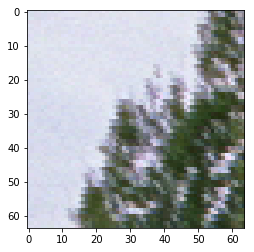

In [272]:
plt.imshow(X_trn[100])

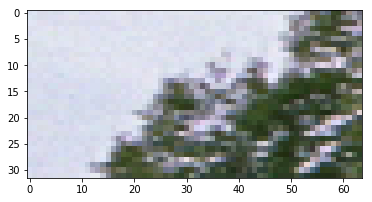

In [273]:
plt.imshow(y_trn[0][100])

## 3. Building Model

Keras functional API: https://keras.io/getting-started/functional-api-guide/

In [274]:
def build_model(input_shape=(None, None, 3)):
    # Input tensor — patch of `input_shape`
    inputs = keras.layers.Input(shape=input_shape, name='input')

    # Common part.
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)

    # I^{even}_{t}
    current_even = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    current_even = keras.layers.Conv2D(
        filters=3, kernel_size=(3, 3), padding='same', strides=(2, 1), activation='sigmoid', name='current_even'
    )(current_even)

    # I^{odd}_{t+1}
    next_odd = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    next_odd = keras.layers.Conv2D(
        filters=3, kernel_size=(3, 3), padding='same', strides=(2, 1), activation='sigmoid', name='next_odd'
    )(next_odd)

    # This creates a model.
    model = keras.models.Model(inputs=inputs, outputs=[current_even, next_odd])

    return model

## 4. Training

__Пайплайн обучения__:
* Определить __таргет__. В нашей задаче это недостающие строки двух последовательных кадров
* Определить __функцию потерь (loss)__. У нас всё просто: хочется, чтобы изображения мало отличались друг от друга, поэтому используем MSE между таргетом и предсказанием сети.
* Выбрать __оптимизатор__. Задача не из простых, но если хочется, чтобы всё быстро полетело, то лучше всего `Adam`.

Шпаргалка по отпимизаторам: https://habr.com/ru/post/318970/

In [275]:
model = build_model()

model.compile(
    optimizer='adam',
    loss={'current_even': 'mse', 'next_odd': 'mse'}
)

In [279]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 6 36928       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, None, 3 18464       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

In [277]:
history = model.fit(X_trn, y_trn, epochs=5, validation_data=(X_vld, y_vld))

Train on 960 samples, validate on 480 samples
Epoch 1/5
960/960 [==============================] - 73s 76ms/sample - loss: 0.0065 - current_even_loss: 0.0032 - next_odd_loss: 0.0032 - val_loss: 0.0110 - val_current_even_loss: 0.0060 - val_next_odd_loss: 0.0051
Epoch 2/5
960/960 [==============================] - 72s 75ms/sample - loss: 0.0046 - current_even_loss: 0.0023 - next_odd_loss: 0.0022 - val_loss: 0.0073 - val_current_even_loss: 0.0040 - val_next_odd_loss: 0.0033
Epoch 3/5
960/960 [==============================] - 72s 75ms/sample - loss: 0.0038 - current_even_loss: 0.0020 - next_odd_loss: 0.0019 - val_loss: 0.0066 - val_current_even_loss: 0.0036 - val_next_odd_loss: 0.0030
Epoch 4/5
960/960 [==============================] - 72s 75ms/sample - loss: 0.0034 - current_even_loss: 0.0017 - next_odd_loss: 0.0017 - val_loss: 0.0062 - val_current_even_loss: 0.0034 - val_next_odd_loss: 0.0028
Epoch 5/5
960/960 [==============================] - 72s 75ms/sample - loss: 0.0033 - current_

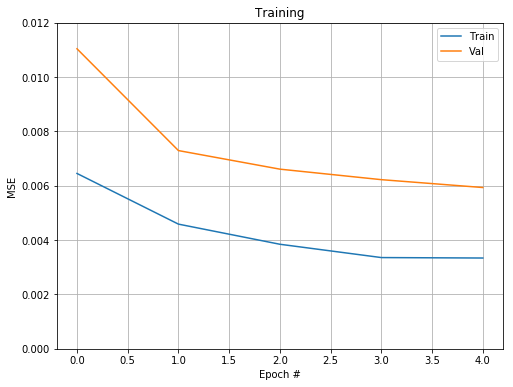

In [317]:
_, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Val')

ax.set_xlabel('Epoch #')
ax.set_ylabel('MSE')
ax.set_title('Training')

ax.legend()
ax.grid()

ax.set_ylim([0, 0.012])

plt.show()

## 5. Evaluation

In [294]:
def evaluate(model, interlaced_image):
    current_even, next_odd = model.predict(interlaced_image[np.newaxis, ...])

    first = np.zeros_like(interlaced_image)
    first[::2] = interlaced_image[::2]
    first[1::2] = current_even[0]
    
    second = np.zeros_like(interlaced_image)
    second[1::2] = interlaced_image[1::2]
    second[::2] = next_odd[0]
    
    return first, second

In [344]:
test_image = np.array(Image.open('tiny_data/test/interlace/0/00000.png')) / 255.

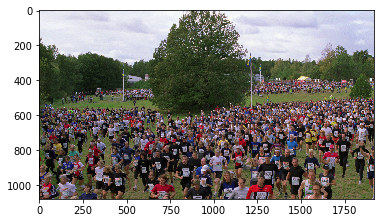

In [345]:
plt.imshow(test_image)

In [346]:
first, second = evaluate(model, test_image)

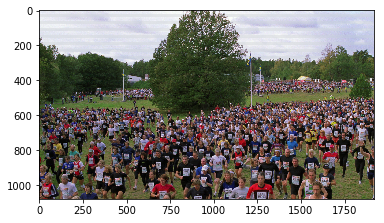

In [347]:
plt.imshow(first)

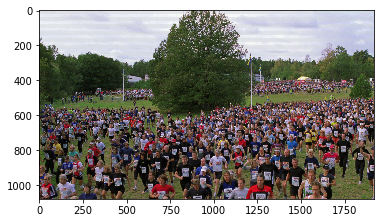

In [348]:
plt.imshow(second)

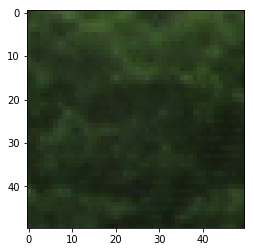

In [349]:
plt.imshow(first[275: 325, 275: 325])